# **Vision Transformer 실습**

## **데이터셋 준비**

#### *Kaggle 데이터셋 로드*
**Stanford Dogs Dataset**  
Number of categories: 120  
Number of images: 20,580

In [1]:
import kagglehub

path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stanford-dogs-dataset


In [2]:
import os
import shutil
# 전처리된 데이터가 저장될 루트 디렉토리 경로 지정
root_path = "/kaggle/processed"
org_image_path = "/kaggle/input/stanford-dogs-dataset/images/Images/"
labels = os.listdir(org_image_path)
# 각 클래스(강아지 품종) 이름들을 불러옴
labels_cnt_list = []
# 각 클래스별 이미지 수 저장
for l in labels:
    labels_cnt_list.append(len(os.listdir(os.path.join(org_image_path, l))))

# /kaggle/input 폴더에 직접 접근 불가; 해당 폴더는 read only임
os.makedirs(os.path.join(root_path, 'data/'), exist_ok=True)
os.makedirs(os.path.join(root_path, 'data/train/'), exist_ok=True)
os.makedirs(os.path.join(root_path, 'data/val/'), exist_ok=True)

for l in labels:
    os.makedirs(os.path.join(root_path, 'data/train/', l), exist_ok=True)
    os.makedirs(os.path.join(root_path, 'data/val/', l), exist_ok=True)

train_img_list = []
train_label_list = []
val_img_list = []
val_label_list = []
# 각 클래스별 이미지 리스트 순회하며 85%는 train, 나머지는 val에 저장
for idx, l in enumerate(labels):
    num_train = int(labels_cnt_list[idx] * 0.85)
    tmp_image_name_list = os.listdir(os.path.join(org_image_path, l))
    for cnt, fname in enumerate(tmp_image_name_list):
        if cnt <= num_train:
          dst_path = os.path.join(root_path, 'data/train/', l, fname)
          shutil.copy(os.path.join(org_image_path, l, fname), dst_path)
          train_img_list.append(dst_path)
          train_label_list.append(idx)
        else:
          dst_path = os.path.join(root_path, 'data/val/', l, fname)
          shutil.copy(os.path.join(org_image_path, l, fname), dst_path)
          val_img_list.append(dst_path)
          val_label_list.append(idx)

#### *CV 알고리즘 PyTorch 구현 패키지 install*

In [3]:
!pip install timm # Vision Transformer 모델을 포함한 PyTorch Image Model 패키지 설치

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

#### *이미지 파일 불러오기 + 전처리 함수 정의*


In [4]:
import torch
from PIL import Image
from torchvision import models, transforms

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, label_list, phase, transform):
        self.img_list = img_list
        self.label_list = label_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        # img = self.img_list[index]

        img_path = self.img_list[index]
        img = Image.open(img_path).convert('RGB')

        transformed_img = self.transform(img, self.phase)
        label = self.label_list[index]

        return transformed_img, label

class MyTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            # train의 경우 이미지 전처리
            'train': transforms.Compose([
                # 데이터 증강을 위해 이미지를 랜덤하게 크롭 및 좌우 반전
                transforms.RandomResizedCrop(
                    (resize, resize), scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                # 이미지를 텐서로 변환
                transforms.ToTensor(),
                # 정규화
                transforms.Normalize(mean, std)
            ]),
            # validation의 경우 이미지 전처리
            'val': transforms.Compose([
                # 이미지 리사이즈
                transforms.Resize((resize, resize)),
                # 이미지를 텐서로 변환
                transforms.ToTensor(),
                # 정규화
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

## **모델 학습**

#### *모델 학습을 위한 train & validation 셋 정의*

In [5]:
size = 224  # 이미지 resize 크기 224*224
# ImageNet 기준 평균 & 표준편차
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# train 데이터 셋 생성, 전처리 함수 호출
train_dataset = MyDataset(img_list=train_img_list, label_list=train_label_list, phase="train", transform=MyTransform(size, mean, std))
# validation 데이터 셋 생성, 전처리 함수 호출
val_dataset = MyDataset(img_list=val_img_list, label_list=val_label_list, phase="val", transform=MyTransform(size, mean, std))

image_datasets = {'train' : train_dataset, 'val' : val_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#### *데이터 로드*

In [6]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

#### *ViT 모델 가져오기*
이미지를 224*224 사이즈의 16개 패치로 나누는 ViT 모델을 가져옴

In [7]:
import timm

num_classes = 120 # Stanford Dogs Dataset 클래스 수
# 사전 학습된 ViT 모델 로드 (이미지 크기 224x224, 패치 크기 16)
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

#### *Loss Function & Optimizer & Scheduler 정의*
Loss는 **CrossEntropy** 사용  
Optimizer는 **Adam** 사용  
**StepLR**로 epoch 마다 학습률 감소시킴

In [8]:
import torch.optim as optims
import torch.nn as nn
from torch.optim import lr_scheduler
# 다중 클래스 분류이므로 CrossEntropyLoss 사용
criterion = nn.CrossEntropyLoss()
optimizer = optims.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999))
# 학습률을 7 epoch마다 0.1배 감소시키는 scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#### *학습 loop*

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    print("{}/{} epoch running now".format(epoch, epochs - 1))

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders_dict[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            exp_lr_scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # 모델 저장
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), './best_model.pth')

0/9 epoch running now
train Loss: 4.8384 Acc: 0.0145
val Loss: 4.7211 Acc: 0.0209
1/9 epoch running now
train Loss: 4.6841 Acc: 0.0231
val Loss: 4.6929 Acc: 0.0202
2/9 epoch running now


KeyboardInterrupt: 

## **시각화**

In [38]:
# 원본 이미지 경로에서 클래스 이름 리스트 생성
class_names = sorted(os.listdir(org_image_path))  # 알파벳 순 정렬

from matplotlib import pyplot as plt
import numpy as np

# 클래스별 이미지 예측 결과를 시각화하는 함수
def visualize_model_by_class(model, dataloader, class_names, max_classes=10):
    model.eval()
    was_training = model.training

    class_sample = {}  # 클래스별 하나씩 샘플을 저장할 dict

    # validation 데이터에서 각 클래스당 1개씩 샘플 수집
    with torch.no_grad():
        for inputs, labels in dataloader:
            for i in range(inputs.size(0)):
                label = labels[i].item()
                if label not in class_sample:
                    class_sample[label] = inputs[i]
                if len(class_sample) >= max_classes:
                    break
            if len(class_sample) >= max_classes:
                break

    # subplot: 1열, max_classes행 구조로 이미지 시각화
    fig, axes = plt.subplots(max_classes, 1, figsize=(6, max_classes * 4))
    if max_classes == 1:
        axes = [axes]  # 하나일 경우도 리스트화

    # 각 클래스 이미지에 대해 예측하고 시각화
    for idx, (label, img_tensor) in enumerate(class_sample.items()):
        input_tensor = img_tensor.unsqueeze(0).to(device)
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)

        # 이미지 복구 (Normalize 해제)
        inp = img_tensor.numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)  # [0, 1] 범위로 제한

        ax = axes[idx]
        ax.axis('off')
        ax.set_title(f"GT: {class_names[label]} | Pred: {class_names[pred.item()]}", fontsize=12)
        ax.imshow(inp)

    plt.tight_layout()
    plt.show()
    model.train(mode=was_training)

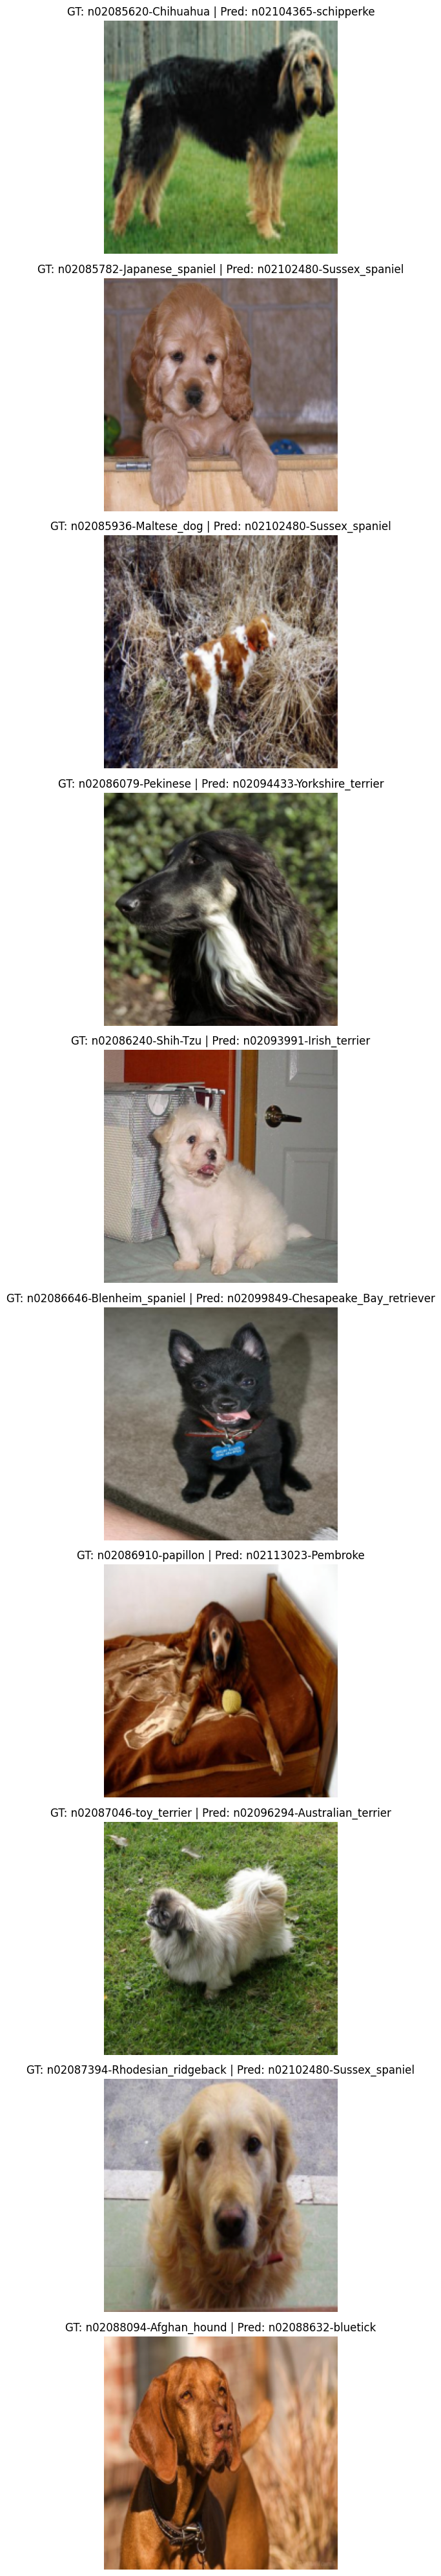

In [39]:
visualize_model_by_class(model, dataloaders_dict['val'], class_names, max_classes=10)

예측 거지같이 함